In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import shapely.geometry
from descartes import PolygonPatch

In [2]:
SAMPLE_SHP_IN_DIR = 'data/Shapefile/GDFigure2/SampleArea.shp'
CENSUS_IN_DIR = 'data/GiveDirectly/Survey/GE_HH_Census_2017-07-17_cleanGPS.csv'

OUT_DIR = 'data/Experiment4/output/'

In [3]:
cmap = plt.get_cmap('coolwarm', 30)
cmap.set_under('#dddddd')

In [4]:
min_lon = 34.040  # 34.044261
max_lon = 34.460  # 34.451611
min_lat = -0.055  # -0.050481
max_lat = 0.315  # 0.310766
step = 0.002

In [5]:
bound, = gpd.read_file(SAMPLE_SHP_IN_DIR)['geometry']
outside = shapely.geometry.box(min_lon, min_lat, max_lon, max_lat).difference(bound)

In [6]:
df = pd.read_csv(
    CENSUS_IN_DIR,
    usecols=['sublocation_code', 'village_code', 'ge', 'hi_sat', 'treat',
             'latitude', 'longitude', 'elevation', 'accuracy', 'eligible',
             'GPS_imputed', 'dist_from_vill'],
    dtype={
        'sublocation_code': 'Int64',
        'village_code': 'Int64',
        'ge': 'Int32',
        'hi_sat': 'Int32',
        'treat': 'Int32',
        'eligible': 'Int32',
        'GPS_imputed': 'Int32'})

In [7]:
# drop non GE households
df = df.loc[df['ge'] == 1, :]

In [8]:
df.loc[:, 'treat_eligible'] = df.loc[:, 'treat'].values * df.loc[:, 'eligible'].values

In [9]:
# snap to grid
df.loc[:, 'grid_lon'] = np.round((df['longitude'].values - min_lon) / step).astype(np.int32)
df.loc[:, 'grid_lat'] = np.round((df['latitude'].values - min_lat) / step).astype(np.int32)

In [10]:
df_group = df.groupby(['grid_lon', 'grid_lat']).agg(
    n_household=pd.NamedAgg(column='treat_eligible', aggfunc='count'),
    eligible=pd.NamedAgg(column='eligible', aggfunc='sum'),
    treat_eligible=pd.NamedAgg(column='treat_eligible', aggfunc='sum'),
)

In [11]:
grid_lon, grid_lat = np.meshgrid(
    np.arange(0, np.round((max_lon - min_lon) / step).astype(np.int32) + 1),
    np.arange(0, np.round((max_lat - min_lat) / step).astype(np.int32) + 1))
grid_shape = grid_lon.shape

df_grid = pd.DataFrame({'grid_lon': grid_lon.flatten(), 'grid_lat': grid_lat.flatten()})

df_grid = pd.merge(df_grid, df_group, how='left', on=['grid_lon', 'grid_lat'])

df_grid.fillna(0, inplace=True)

In [12]:
df_grid.loc[:, 'treat_pct'] = df_grid.apply(
    lambda x: -1 if x['eligible'] == 0 else x['treat_eligible'] / x['eligible'], axis=1)

In [13]:
raster = df_grid['treat_pct'].values.astype(int).reshape(grid_shape)[::-1, :]

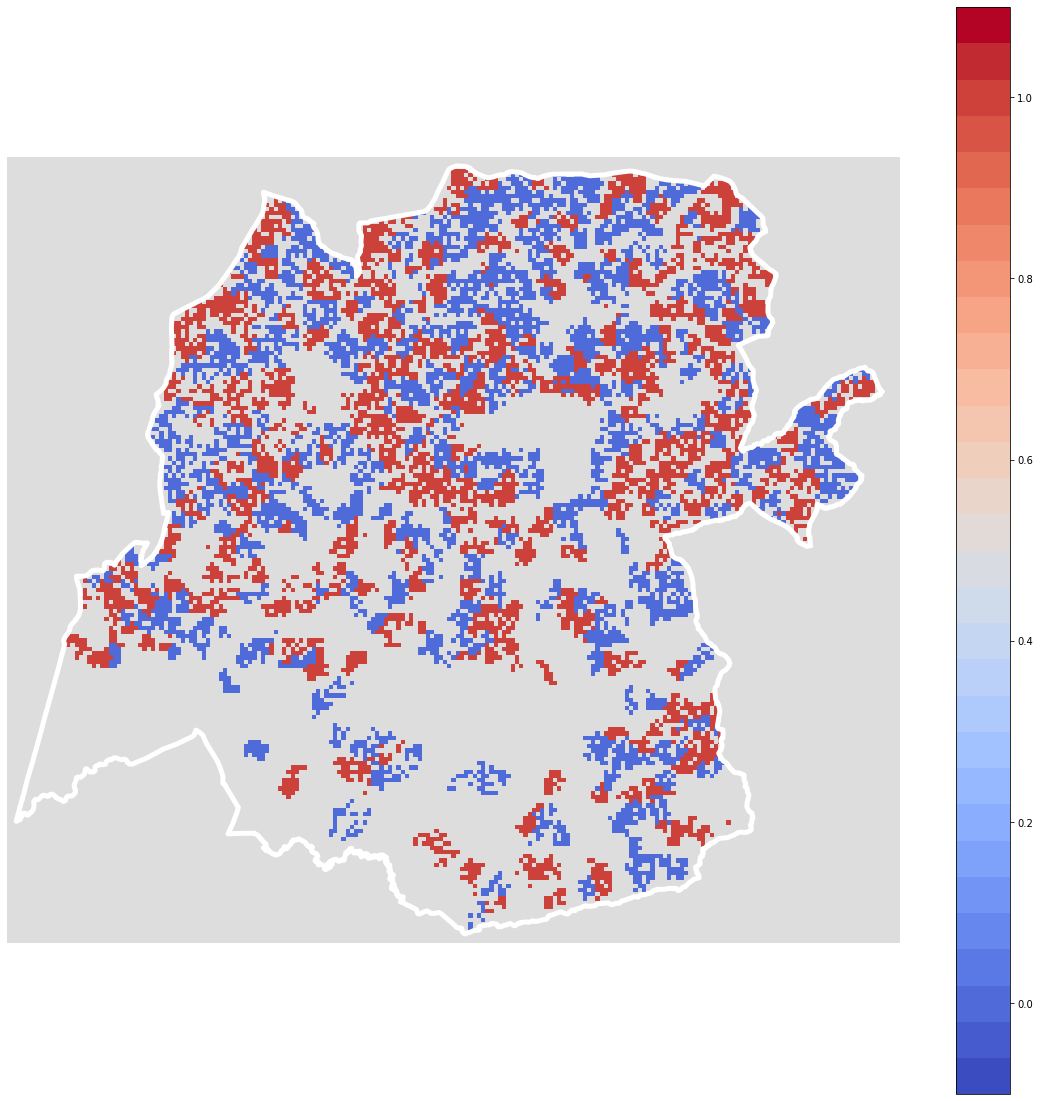

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(raster,
               extent=(min_lon, max_lon, min_lat, max_lat),
               cmap=cmap,
               vmin=-0.1,
               vmax=1.1)
ax.plot(*bound.exterior.xy, color='white', linewidth=5)
ax.add_patch(PolygonPatch(outside, facecolor='#dddddd', edgecolor='#dddddd'))
ax.axis('off')
fig.colorbar(im)
fig.savefig(os.path.join(OUT_DIR, 'treat_pct.pdf'))